### Credit Risk Model using Machine Leanring 

Dataset: https://www.kaggle.com/competitions/GiveMeSomeCredit/data

In this project, we aim to predict the likelihood of a customer defaulting on their credit within two years, using a dataset of past customer behavior. With increasing financial instability, accurately predicting credit defaults is crucial for lenders to make informed decisions, minimize risk, and offer responsible lending solutions. The dataset contains key attributes, such as debt ratio, monthly income, and age, which can help build a model capable of identifying high-risk customers.


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


We start by loading and inspecting the dataset to understand its structure, the types of variables, and basic statistics like means, medians, and ranges. This helps identify potential issues such as missing values or incorrect data types.

In [17]:
train = pd.read_csv("GiveMeSomeCredit/cs-training.csv").drop(['Unnamed: 0'], axis=1)

train.describe()


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


##### Handling Duplicates
We remove any duplicate entries from the dataset to ensure that the analysis is based on unique observations. Duplicates can distort our visualizations and model performance if not handled properly.

In [18]:
train_clean_data = train.drop_duplicates()
print(f'Number of rows after duplicates have been dropped: {len(train_clean_data)}')

Number of rows after duplicates have been dropped: 149391


### Missing Data Analysis
To ensure we handle missing data properly, we first identify how many missing values there are in each column, both in terms of counts and percentages.

In [19]:
missing_values_percentage = train_clean_data.isnull().sum() / len(train_clean_data) * 100
print(missing_values_percentage)


SeriousDlqin2yrs                         0.000000
RevolvingUtilizationOfUnsecuredLines     0.000000
age                                      0.000000
NumberOfTime30-59DaysPastDueNotWorse     0.000000
DebtRatio                                0.000000
MonthlyIncome                           19.560081
NumberOfOpenCreditLinesAndLoans          0.000000
NumberOfTimes90DaysLate                  0.000000
NumberRealEstateLoansOrLines             0.000000
NumberOfTime60-89DaysPastDueNotWorse     0.000000
NumberOfDependents                       2.562403
dtype: float64


### Handling Missing Data
- For the **MonthlyIncome** field, which has 19.25% missing data, we use median imputation because the median is less sensitive to extreme values than the mean.
- For the **NumberOfDependents** field, which has 2.5% missing data, we also use median imputation, as the percentage of missing data is small and the median is appropriate for a numerical variable like this.

In [20]:
# Handle MonthlyIncome missing data 
median_income = train_clean_data['MonthlyIncome'].median()
train_clean_data.loc[:, 'MonthlyIncome'] = train_clean_data['MonthlyIncome'].fillna(median_income)

#Handle NumberOfDependants missing data
median_dependants = train_clean_data['NumberOfDependents'].median()
train_clean_data.loc[:, 'NumberOfDependents'] = train_clean_data['NumberOfDependents'].fillna(median_dependants)

### Data Processing 

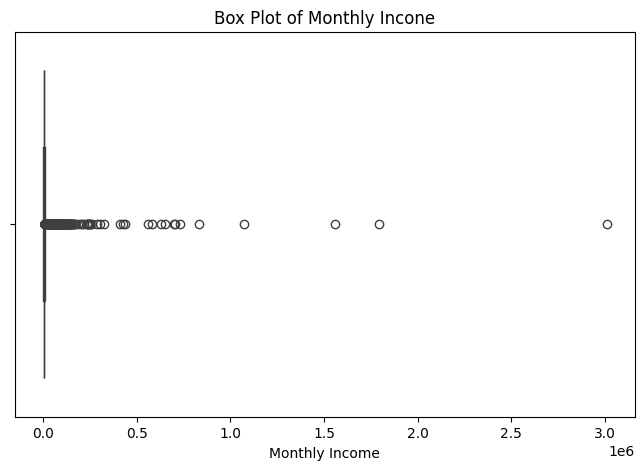

In [21]:
# Box plot for Debt Ratio
plt.figure(figsize=(8, 5))
sns.boxplot(x=train_clean_data['MonthlyIncome'])
plt.title('Box Plot of Monthly Incone')
plt.xlabel('Monthly Income')
plt.show()

<Axes: xlabel='DebtRatio', ylabel='Density'>

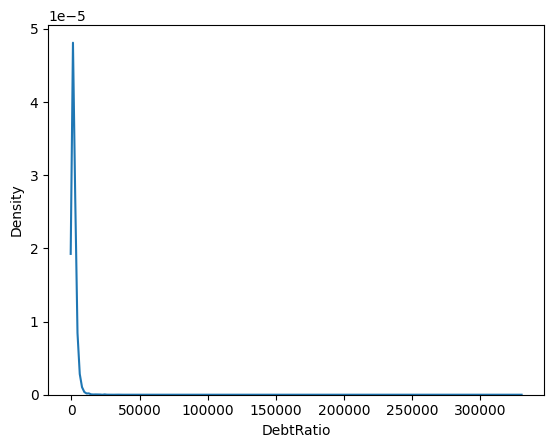

In [22]:
sns.kdeplot(train_clean_data['DebtRatio'])


#### DebtRatio Capping

DebtRatio shows a skewed distribution, with values going as high as 329,664. Such extreme values are unlikely to be legitimate and may represent data entry errors or exceptional cases that do not generalize well. Hence, we capped the `DebtRatio` at the 97th percentile to remove extreme outliers while preserving the majority of the data distribution.

In [ ]:
debt_ratio_97percentile = np.percentile(train_clean_data['DebtRatio'], 97)
train_clean_data['DebtRatio_Cap'] = np.where(train_clean_data['DebtRatio'] > debt_ratio_97percentile, debt_ratio_97percentile, train_clean_data['DebtRatio'])

train_clean_data['DebtRatio_Cap'].describe()

### Monthly Incone and RevolvingUtilizationOfUnsecuredLines Capping 
Both feature also have skewed distribution which may affect model performance , these values may represent extreme cases in the case of MonthlyIncome and data errors in the case of RevolvingUtilizationOfUnsecuredLines, hence we will also cap them to the 97th percentile. 

In [ ]:
monthly_income_97percentile =  np.percentile(train_clean_data['MonthlyIncome'], 97)
ruoucl_97percentile = np.percentile(train_clean_data["RevolvingUtilizationOfUnsecuredLines"], 97)

train_clean_data['MonthlyIncome_cap'] = np.where(train_clean_data['MonthlyIncome'] > monthly_income_97percentile, monthly_income_97percentile, train_clean_data["MonthlyIncome"])

train_clean_data['RevolvingUtilizationOfUnsecuredLines_cap'] = np.where(train_clean_data['RevolvingUtilizationOfUnsecuredLines'] > 
                                                                        ruoucl_97percentile, ruoucl_97percentile, train_clean_data['RevolvingUtilizationOfUnsecuredLines'])

 

### Feature Scaling 
Feature scaling is important because it brings all features into a similar range, which improves the performance and convergence of many machine learning algorithms by preventing features with larger ranges from disproportionately influencing the model.

In [ ]:
cols_to_scale = ['MonthlyIncome_cap', 'RevolvingUtilizationOfUnsecuredLines_cap', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio_Cap', 'NumberOfOpenCreditLinesAndLoans', 
                 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

scaler = MinMaxScaler()

train_clean_data[cols_to_scale] = scaler.fit_transform(train_clean_data[cols_to_scale])



### Resampling 
Resampling, particularly using SMOTE (Synthetic Minority Over-sampling Technique), is essential when dealing with imbalanced data, as it helps create a balanced class distribution by generating synthetic samples for the minority class. This approach improves the model’s ability to learn patterns from both classes, leading to more accurate predictions and reducing bias toward the majority class.

In [26]:
from imblearn.over_sampling import SMOTE

X = train_clean_data.drop(columns=['MonthlyIncome', 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs'])
y = train_clean_data['SeriousDlqin2yrs']

smote = SMOTE(random_state=42)
X_resampled , y_resampled = smote.fit_resample(X, y)

train_resampled = pd.DataFrame(X_resampled, columns=X.columns)
train_resampled['SeriousDlqin2yrs'] = y_resampled

print(train_resampled['SeriousDlqin2yrs'].value_counts())

SeriousDlqin2yrs
1    139382
0    139382
Name: count, dtype: int64


### Model Building 

In [27]:
# Data Split 

X  =  train_resampled.drop(columns=['SeriousDlqin2yrs'])
y = train_resampled['SeriousDlqin2yrs']

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import xgboost as xgb 

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)



In [29]:
# Model Evaluation 
from sklearn.metrics import classification_report, accuracy_score

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9578677380589385

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     27889
           1       0.98      0.93      0.96     27864

    accuracy                           0.96     55753
   macro avg       0.96      0.96      0.96     55753
weighted avg       0.96      0.96      0.96     55753



### Model Perfomace Evaluation 

Overall Model perfomance is very promising.

##### Precision 

Class 0(Non Defaulters): 0.94
Class 1(Default):  0.98

Precision measures the accuracy of positive predictions. A precision of 0.98 for class 1 indicates that when the model predicts a default, it is correct 98% of the time. The precision of 0.94 for class 0 is also good, indicating that 94% of non-default predictions are correct.


#### Recall 

Class 0(non defaulters): 0.98
Class 1 (defaulters): 0.93

Recall measures the ability to find all positive instances. A recall of 0.98 for class 0 indicates that the model captures 98% of the true non-default instances. For class 1, a recall of 0.93 indicates that 93% of actual defaults are correctly identified.


#### F1-Score 

Class 0: 0.96
Class 1: 0.96

The F1-score is the harmonic mean of precision and recall. The scores being equal at 0.96 for both classes indicate a good balance between precision and recall, making this model effective in distinguishing between the two classes.